### Part 5: Perform a PCA

In [2]:
import pandas as pd 
from matplotlib import pyplot as plt
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn import metrics
import numpy as np
import sklearn
import psycopg2 as psy
from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL
from pandas import DataFrame
import seaborn as sns
from sklearn.cluster import KMeans

%matplotlib inline

In [3]:
PATH = '/Users/cguy/Downloads'
ap_info = pd.read_csv(PATH + '/airports.csv')
ap_ops = pd.read_csv(PATH + '/Airport_operations.csv')
ap_cancels = pd.read_csv(PATH + '/airport_cancellations.csv')

In [4]:
ap_info.columns = [c.lower().replace(' ','_') for c in ap_info.columns] 
ap_ops.columns = [c.lower().replace(' ','_') for c in ap_ops.columns]
ap_cancels.columns = [c.lower().replace(' ','_') for c in ap_cancels.columns]

print ap_info.columns
print ap_ops.columns
print ap_cancels.columns

Index([u'key', u'locid', u'ap_name', u'alias', u'facility_type', u'faa_region',
       u'county', u'city', u'state', u'ap_type', u'latitude', u'longitude',
       u'boundary_data_available'],
      dtype='object')
Index([u'airport', u'year', u'departures_for_metric_computation',
       u'arrivals_for_metric_computation', u'percent_on-time_gate_departures',
       u'percent_on-time_airport_departures', u'percent_on-time_gate_arrivals',
       u'average_gate_departure_delay', u'average_taxi_out_time',
       u'average_taxi_out_delay', u'average_airport_departure_delay',
       u'average_airborne_delay', u'average_taxi_in_delay',
       u'average_block_delay', u'average_gate_arrival_delay'],
      dtype='object')
Index([u'airport', u'year', u'departure_cancellations',
       u'arrival_cancellations', u'departure_diversions',
       u'arrival_diversions'],
      dtype='object')


In [1]:
# Will focus unsupervised learning on airport operational data. 
# In other words, I am excluding airport cancellations and diversions data. 
#                        Will need to include this data in future analysis.

In [5]:
ap_ops.head()

,airport,year,departures_for_metric_computation,arrivals_for_metric_computation,percent_on-time_gate_departures,percent_on-time_airport_departures,percent_on-time_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average_airport_departure_delay,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay
0,ABQ,2004,53971,53818,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2005,51829,51877,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2006,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2007,53255,53611,0.8005,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,ABQ,2008,49589,49512,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


In [9]:
ap_ops.columns.get_loc("airport")

0

In [10]:
ap_ops.columns.get_loc("year")

1

In [11]:
ap_ops.columns.get_loc("average_gate_arrival_delay")

14

In [64]:
ap_ops.columns.get_loc("average_airport_departure_delay")

10

In [63]:
# First, looking at correlation matrix

x = ap_ops.drop(['airport','year', 'average_airport_departure_delay'],axis=1)
x - (x.mean()) / x.std()
y = ap_ops['average_airport_departure_delay']

x_corr = np.corrcoef(x.values.T)
x.corr()

,departures_for_metric_computation,arrivals_for_metric_computation,percent_on-time_gate_departures,percent_on-time_airport_departures,percent_on-time_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay
departures_for_metric_computation,1.000000,0.999817,0.122172,-0.164180,0.209147,-0.055330,0.652991,0.628636,0.336448,0.830254,0.293909,-0.055719
arrivals_for_metric_computation,0.999817,1.000000,0.122177,-0.163782,0.209209,-0.055988,0.651093,0.627942,0.335341,0.829301,0.291079,-0.056364
percent_on-time_gate_departures,0.122172,0.122177,1.000000,0.896319,0.920834,-0.960398,0.034791,0.112712,-0.352806,0.156025,-0.402450,-0.860146
percent_on-time_airport_departures,-0.164180,-0.163782,0.896319,1.000000,0.842921,-0.906287,-0.370999,-0.331784,-0.564241,-0.155152,-0.574753,-0.864986
percent_on-time_gate_arrivals,0.209147,0.209209,0.920834,0.842921,1.000000,-0.913605,-0.017341,0.050570,-0.362817,0.181027,-0.525587,-0.954857
average_gate_departure_delay,-0.055330,-0.055988,-0.960398,-0.906287,-0.913605,1.000000,0.094702,0.002276,0.405513,-0.067174,0.477748,0.916972
average_taxi_out_time,0.652991,0.651093,0.034791,-0.370999,-0.017341,0.094702,1.000000,0.915922,0.540622,0.685059,0.521179,0.206263
average_taxi_out_delay,0.628636,0.627942,0.112712,-0.331784,0.050570,0.002276,0.915922,1.000000,0.523337,0.698402,0.462806,0.132937
average_airborne_delay,0.336448,0.335341,-0.352806,-0.564241,-0.362817,0.405513,0.540622,0.523337,1.000000,0.243301,0.560390,0.449821
average_taxi_in_delay,0.830254,0.829301,0.156025,-0.155152,0.181027,-0.067174,0.685059,0.698402,0.243301,1.000000,0.368078,-0.018175


In [66]:
x.head()

,departures_for_metric_computation,arrivals_for_metric_computation,percent_on-time_gate_departures,percent_on-time_airport_departures,percent_on-time_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay
0,53971,53818,0.8030,0.7809,0.7921,10.38,9.89,2.43,2.46,0.83,2.55,10.87
1,51829,51877,0.8140,0.7922,0.8001,9.60,9.79,2.29,2.26,0.89,2.34,10.24
2,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,2.12,0.84,2.66,11.82
3,53255,53611,0.8005,0.7704,0.7647,11.29,10.34,2.40,2.19,1.29,3.06,12.71
4,49589,49512,0.8103,0.7844,0.7875,10.79,10.41,2.41,1.82,1.03,2.79,11.48


In [67]:
x.columns.get_loc("average_gate_departure_delay")

5

In [68]:
x.columns.get_loc("average_gate_arrival_delay")

11

In [69]:
# Establish x and y variables. Average_airport_departure_delay will be target variable for this analysis...
x = ap_ops.ix[:,5:11].values
y = ap_ops.ix[:,10].values

In [70]:
# Standardize data

xStand = StandardScaler().fit_transform(x)


In [71]:
# Calculate eigenvectors and eigenvalues from covariance matrix.

covMat = np.cov(xStand.T)
eigenValues, eigenVectors = np.linalg.eig(covMat)

In [72]:
print(eigenValues)
print(eigenVectors)

[  3.86419256e+00   1.89996361e+00   1.08873327e-01   9.28701547e-02
   4.02666751e-02   9.76524758e-04]
[[-0.4984473   0.03953004 -0.19916433  0.31682082  0.78038771  0.03067291]
 [-0.43649204  0.31470396  0.83809549  0.01516292 -0.08625129 -0.01904906]
 [ 0.46590711 -0.26875919  0.35675639  0.271566    0.31713505 -0.6396102 ]
 [ 0.22635049  0.6299112  -0.15261822  0.69631367 -0.20924587  0.00696091]
 [ 0.19541917  0.65563106 -0.10823427 -0.58367231  0.3122049  -0.28652982]
 [ 0.50451201  0.02295812  0.30926917 -0.01097642  0.37646429  0.71235335]]


In [73]:
# Sorting eigenpairs from highest to lowest

eigenPairs = [(np.abs(eigenValues[i]), eigenVectors[:,i]) for i in range(len(eigenValues))]
eigenPairs.sort()
eigenPairs.reverse()
for i in eigenPairs:
    print(i[0])

3.86419256216
1.8999636137
0.108873326725
0.0928701547477
0.0402666750501
0.000976524758233


In [74]:
totalEigen = sum(eigenValues)
varExpl = [(i / totalEigen)*100 for i in sorted(eigenValues, reverse=True)]

In [75]:
print(varExpl)


[64.326630047923416, 31.628407362378713, 1.8123978289563489, 1.5459954416975059, 0.67031325885938631, 0.016256060184622764]


In [76]:
cvarex = np.cumsum(varExpl)


In [77]:
print(cvarex)


[ 64.32663005  95.95503741  97.76743524  99.31343068  99.98374394 100.        ]


In [78]:
pcask = PCA(n_components=2)
print pcask.fit(xStand).components_ # See the eigenvectors
xPC = pcask.fit_transform(xStand) # Use the eigenvectors to transform xStand onto new axes

[[-0.4984473  -0.43649204  0.46590711  0.22635049  0.19541917  0.50451201]
 [-0.03953004 -0.31470396  0.26875919 -0.6299112  -0.65563106 -0.02295812]]


In [79]:
PCdf = pd.DataFrame(xPC, columns=['PC1','PC2'])


In [113]:
# airports2 = ap_ops[['airport', 'year']]

airports2 = ap_ops[['average_airport_departure_delay', 'airport']]


In [114]:
airport_pca = airports2.join(PCdf, on=None, how='left')


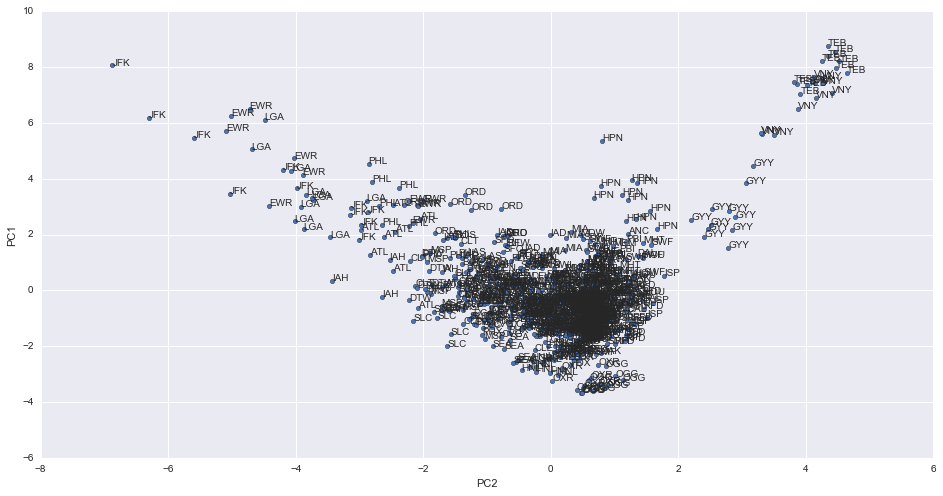

In [115]:
graph = airport_pca.plot(kind='scatter', x='PC2', y='PC1', figsize=(16,8))

for i, airport in enumerate(ap_ops['airport']):
    graph.annotate(airport, (airport_pca.iloc[i].PC2, airport_pca.iloc[i].PC1))

In [116]:
weight_2d_projection = np.hstack((eigenPairs[0][1].reshape(eigenVectors.shape[1],1),
                                  eigenPairs[1][1].reshape(eigenVectors.shape[1],1)))

print 'Weight data 2d PCA projection matrix:\n', weight_2d_projection

Weight data 2d PCA projection matrix:
[[-0.4984473   0.03953004]
 [-0.43649204  0.31470396]
 [ 0.46590711 -0.26875919]
 [ 0.22635049  0.6299112 ]
 [ 0.19541917  0.65563106]
 [ 0.50451201  0.02295812]]


In [117]:
Z = x.dot(weight_2d_projection)


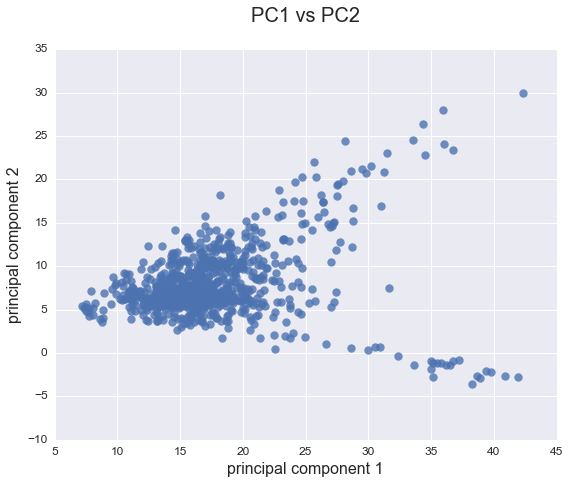

In [121]:
fig = plt.figure(figsize=(9,7))

ax = fig.gca()
ax = sns.regplot(Z[:,0], Z[:,1],
                 fit_reg=False, scatter_kws={'s':70}, ax=ax)

ax.set_xlabel('principal component 1', fontsize=16)
ax.set_ylabel('principal component 2', fontsize=16)


for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
ax.set_title('PC1 vs PC2\n', fontsize=20)

plt.show()

In [137]:
ap_ops_2 = ap_ops.drop(['airport','year','average_airport_departure_delay','arrivals_for_metric_computation','departures_for_metric_computation'],axis=1)


ap_ops_pcs = ap_ops_2.copy

ap_ops_pcs = (ap_ops_2 - ap_ops_2.mean()) / ap_ops_2.std()

ap_ops_pcs['PC1'] = Z[:,0]
ap_ops_pcs['PC2'] = Z[:,1]

In [138]:
ap_ops_pcs = pd.melt(ap_ops_pcs, id_vars=['PC1','PC2'])


In [140]:
ap_ops_pcs.head()


,PC1,PC2,variable,value
0,12.919203,5.591224,percent_on-time_gate_departures,0.416462
1,12.042617,5.628379,percent_on-time_gate_departures,0.534284
2,13.207075,5.290138,percent_on-time_gate_departures,0.366119
3,13.885202,5.620921,percent_on-time_gate_departures,0.389684
4,13.335275,5.799216,percent_on-time_gate_departures,0.494653


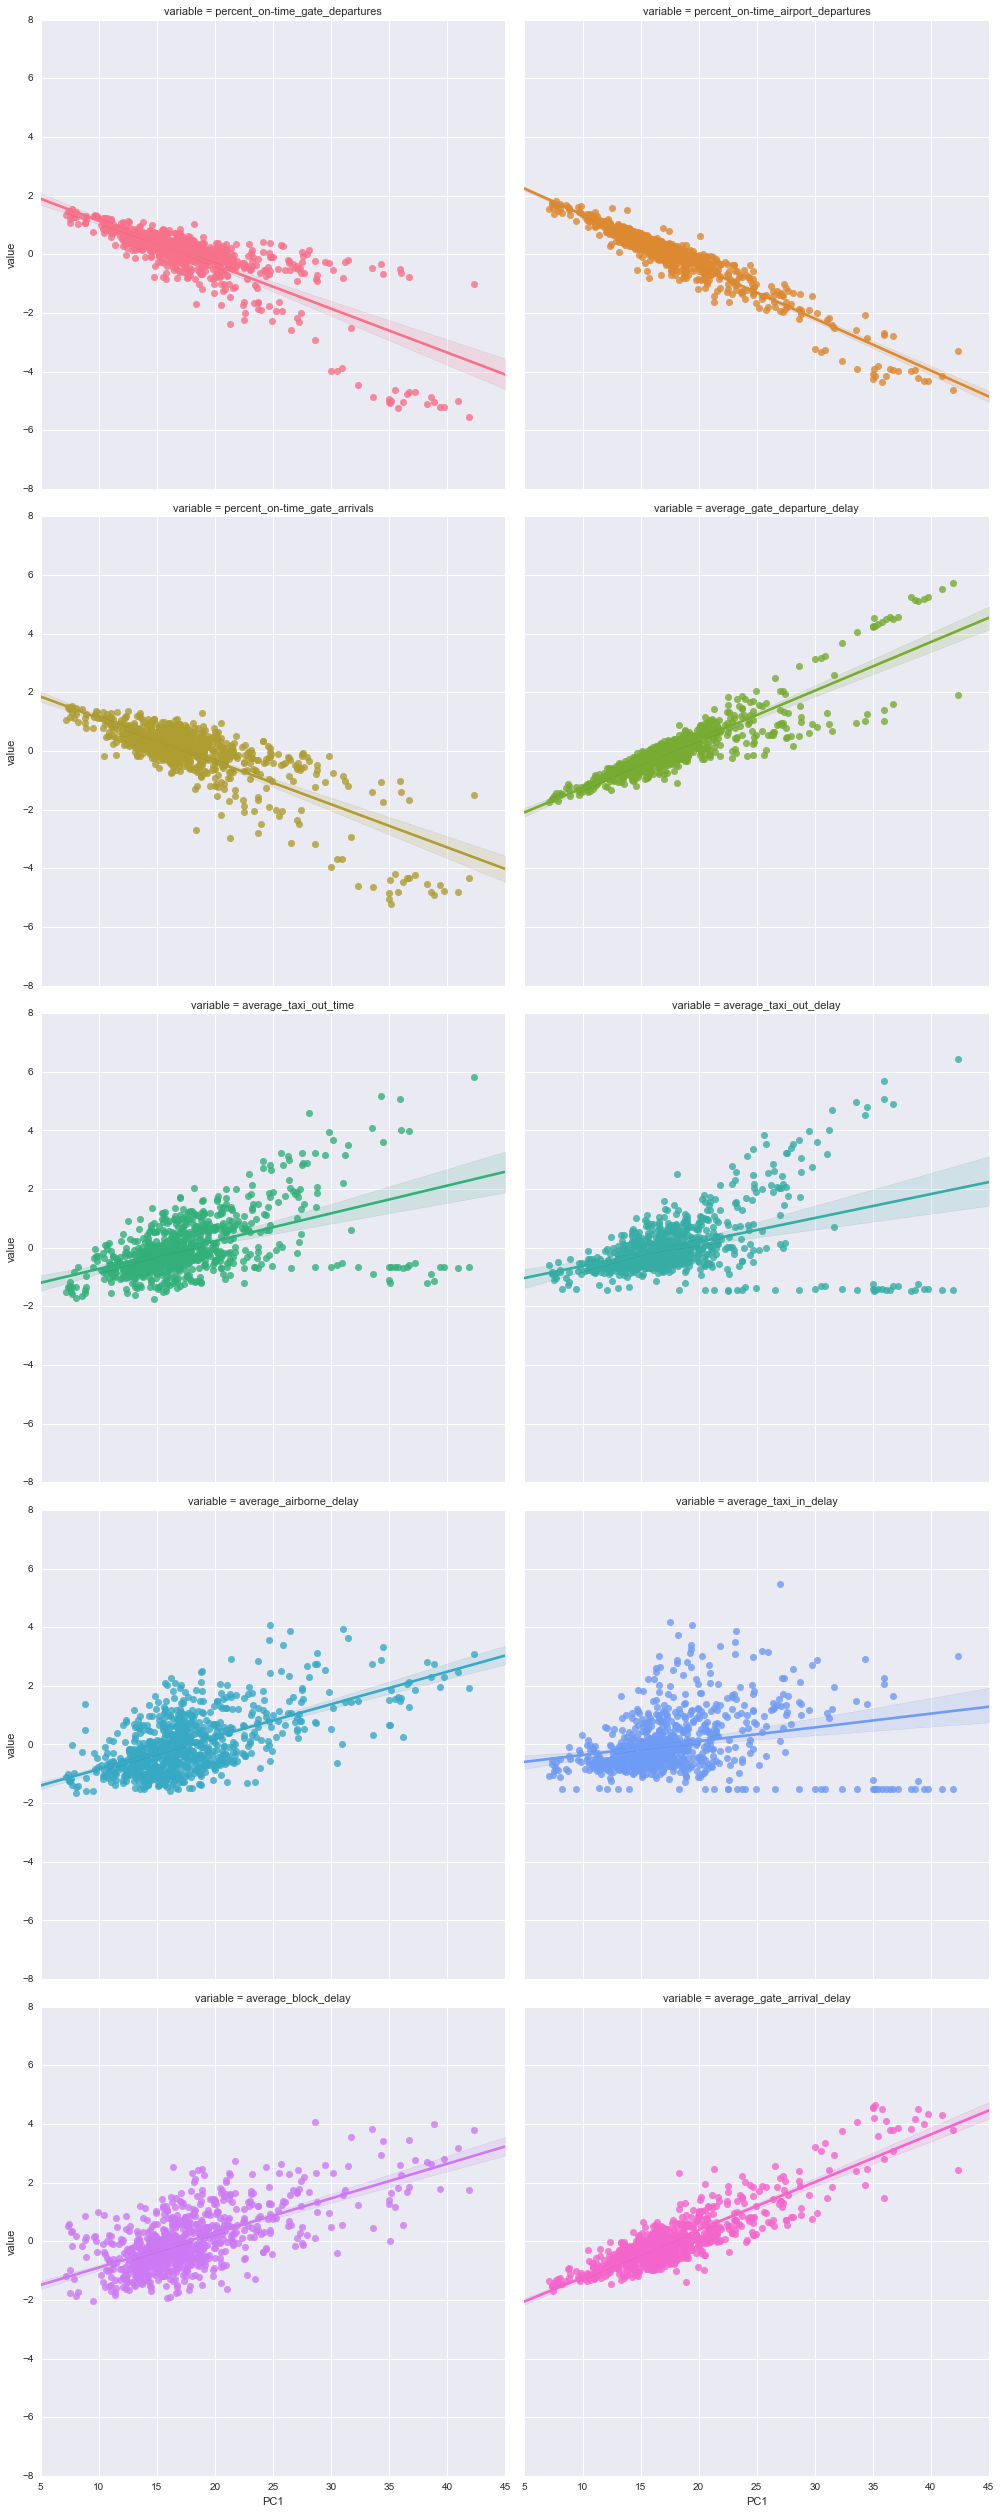

In [141]:
pc1 = sns.lmplot(x="PC1", y="value", col="variable", hue="variable", 
                 data=ap_ops_pcs, col_wrap=2, size=7, scatter_kws={'s':50})

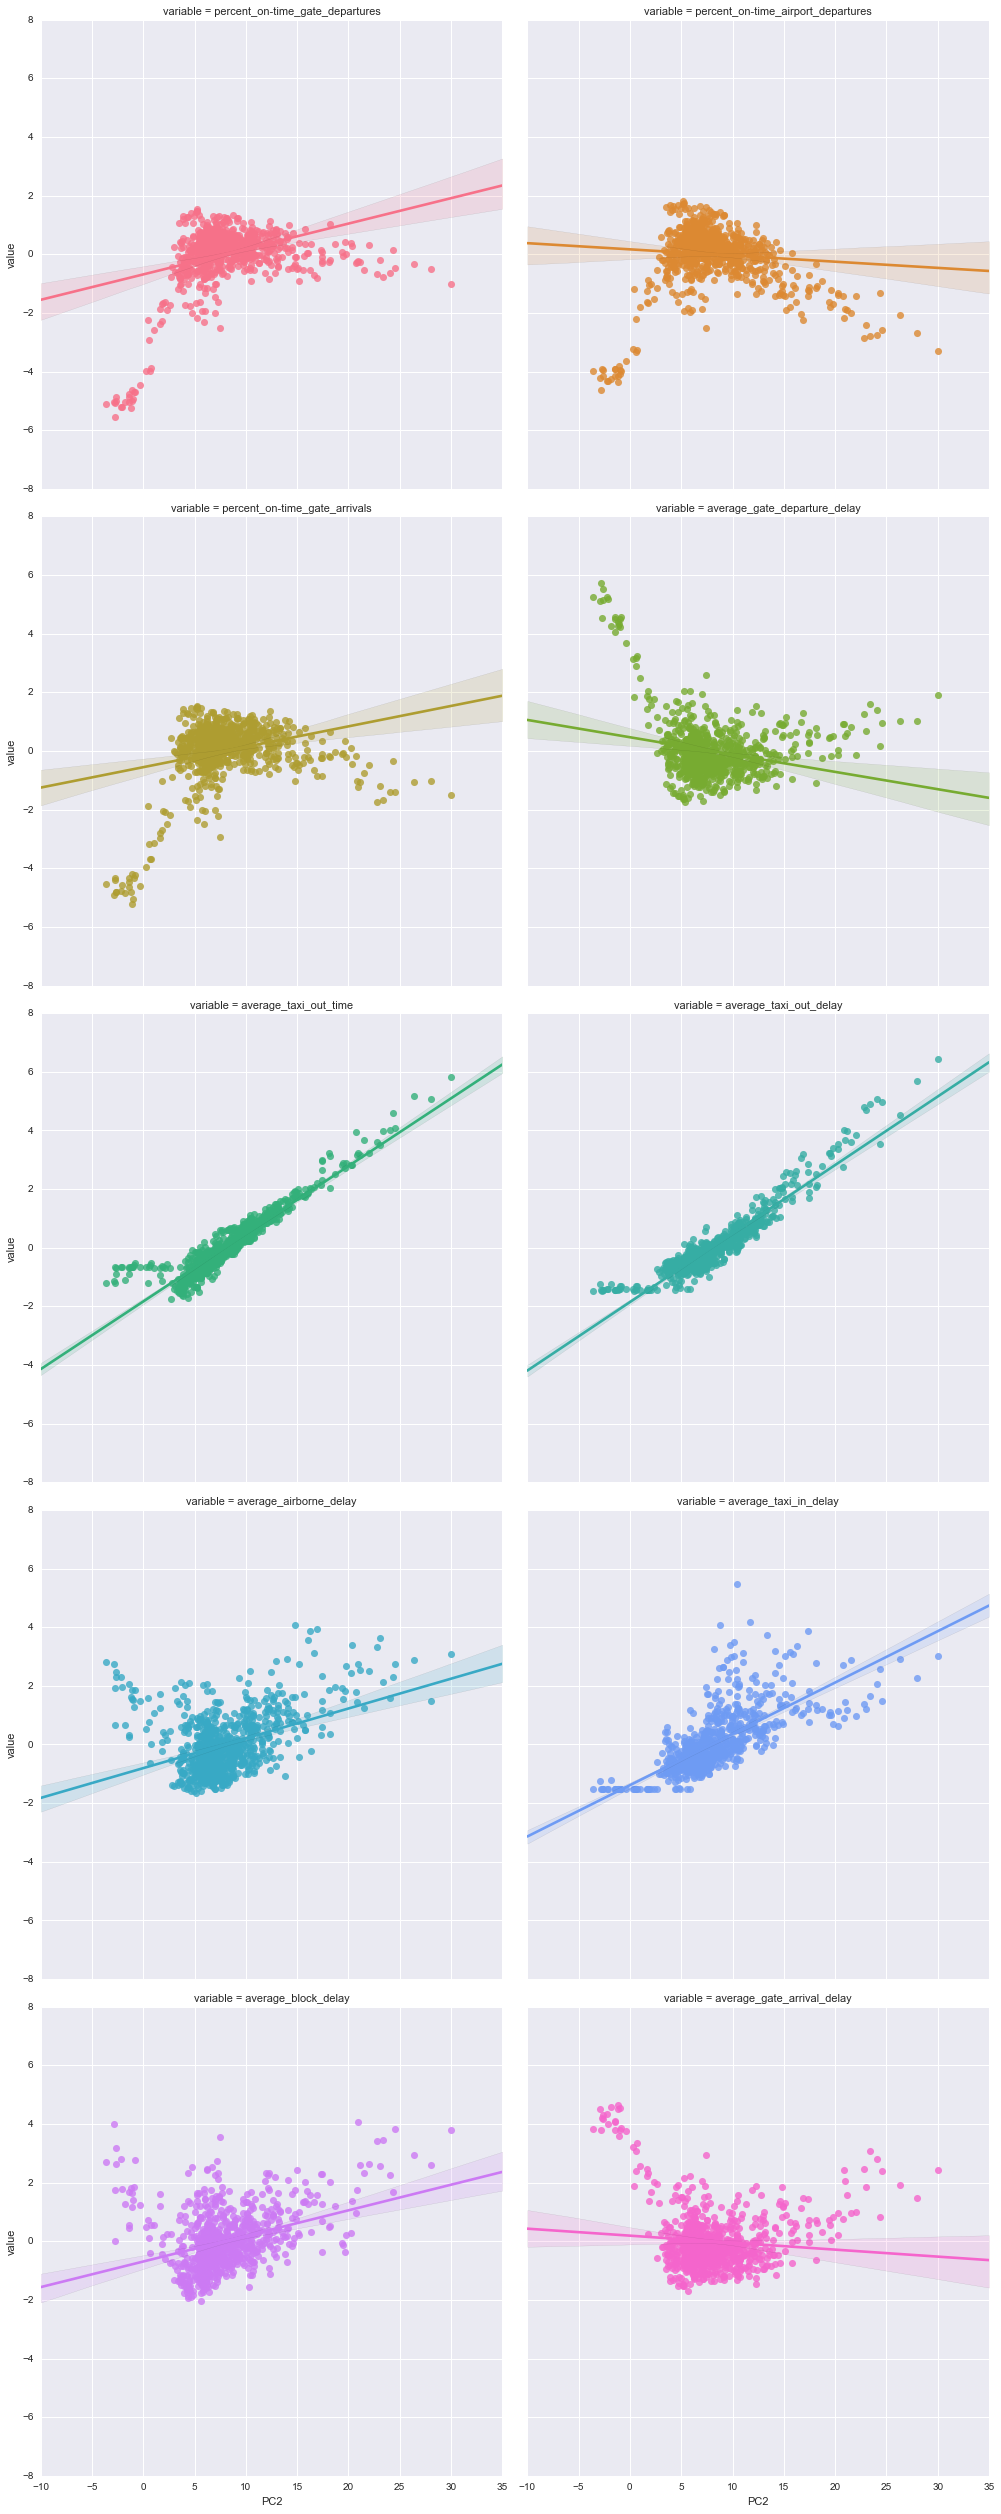

In [142]:
pc2 = sns.lmplot(x="PC2", y="value", col="variable", hue="variable", 
                 data=ap_ops_pcs, col_wrap=2, size=7, scatter_kws={'s':50})

# K-Means Cluster Analysis

In [150]:
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit(xStand)


In [151]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [152]:
print(centroids)


[[-1.3195325  -0.37792141  0.5357734   2.28461013  2.46813718  1.51106806]
 [ 0.29317339  0.22902625 -0.23504412 -0.20126632 -0.19262287 -0.29397422]
 [-2.96884159 -3.55807508  3.37089451 -0.57793001 -1.08750521  2.62036397]]


In [153]:
metrics.silhouette_score(x, labels, metric='euclidean')


0.57331029733470662

In [154]:
airport_pca['cluster'] = pd.Series(clusters.labels_)


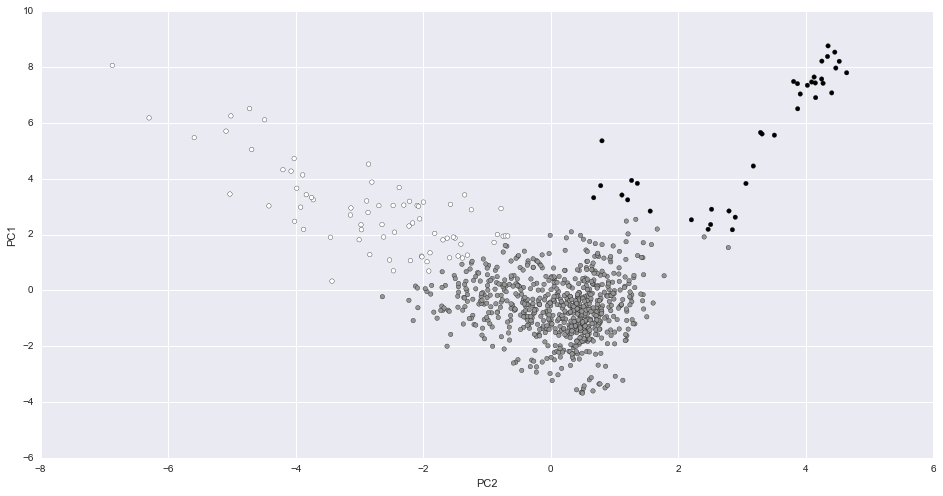

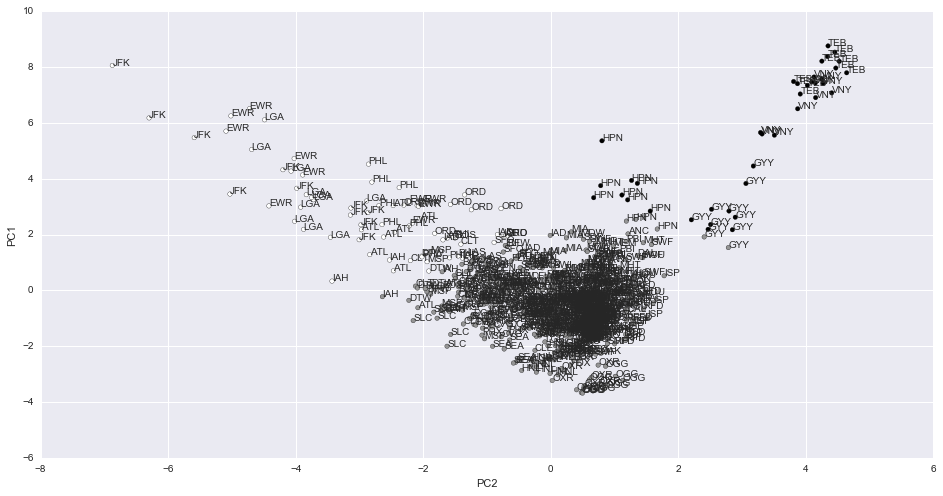

In [155]:
graph = airport_pca.plot(
    kind='scatter',
    x='PC2',y='PC1',
    c=airport_pca.cluster.astype(np.float), 
    figsize=(16,8))

graph2 = airport_pca.plot(
    kind='scatter',
    x='PC2',y='PC1',
    c=airport_pca.cluster.astype(np.float), 
    figsize=(16,8))

for i, airport in enumerate(ap_ops['airport']):
    graph2.annotate(airport, (airport_pca.iloc[i].PC2, airport_pca.iloc[i].PC1))

### Part 7: Write an analysis plan of your findings 

Create a writeup on the interpretation of findings including an executive summary with conclusions and next steps. Put it on your blog, and include the link here.

Which operational features are most correlated with delays?

What should the airport's next steps be?